# Notebook 4: The DCF Engine (Valuation).

Key Findings:

* The Valuation Gap: The difference between the Bear Case (-$116B) and Bull Case (+$257B) is massive. This proves that the "Demand Side" value of the industry hinges almost entirely on electricity prices staying healthy (above ~$60/MWh).

* Bear Case Warning: In the Bear Case ($50/MWh), the entire global fleet has a negative NPV. This implies that without subsidies or higher power prices, many plants would technically be worth more dead (shut down) than alive in a low-price environment.

* Top Assets: The most valuable reactors (like Shin-Hanul-2 and Peach Bottom) are those with massive capacity (>1000 MW), high load factors (>90%), and long remaining lives.

Block 1: Setup & Parameters

We define the WACC (8%) and load the financial schedule.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid")

print("--- Notebook 4: The DCF Engine (Valuation) ---")

# 1. Load the Financial Projections from Notebook 3
try:
    df_financials = pd.read_csv('fleet_financial_projections.csv')
    print("Financial Projections loaded successfully.")
except FileNotFoundError:
    print("Error: 'fleet_financial_projections.csv' not found. Please run Notebook 3 first.")

# 2. Define Valuation Parameters
CURRENT_YEAR = 2025
WACC = 0.08 # Weighted Average Cost of Capital (Discount Rate) - Base assumption 8%

print(f"Valuation Year: {CURRENT_YEAR}")
print(f"Discount Rate (WACC): {WACC:.1%}")
print(df_financials.head())

--- Notebook 4: The DCF Engine (Valuation) ---
Financial Projections loaded successfully.
Valuation Year: 2025
Discount Rate (WACC): 8.0%
           Reactor name Country Type  Net Capacity, MWe Grid Connection Date  \
0  AKADEMIK LOMONOSOV-1  RUSSIA  PWR                 32           2019-12-19   
1  AKADEMIK LOMONOSOV-1  RUSSIA  PWR                 32           2019-12-19   
2  AKADEMIK LOMONOSOV-1  RUSSIA  PWR                 32           2019-12-19   
3  AKADEMIK LOMONOSOV-1  RUSSIA  PWR                 32           2019-12-19   
4  AKADEMIK LOMONOSOV-1  RUSSIA  PWR                 32           2019-12-19   

   Avg_Load_Factor  Age  Assumed_Lifespan  Remaining_Life  Projection_Year  \
0            35.62    6                60              54             2025   
1            35.62    6                60              54             2026   
2            35.62    6                60              54             2027   
3            35.62    6                60              54            

Block 2: Discounting Cash Flows

We calculate the Present Value (PV) of every future EBITDA dollar.

In [14]:
print("Discounting Future Cash Flows to Present Value...")

# 1. Calculate Discount Factor
# We assume mid-year discounting usually, but for simplicity, we'll use end-of-year
df_financials['Discount_Factor'] = 1 / ((1 + WACC) ** (df_financials['Projection_Year'] - CURRENT_YEAR))

# 2. Calculate Present Value (PV) of EBITDA for each scenario
scenarios = ['Bear_Case', 'Base_Case', 'Bull_Case']

for scen in scenarios:
    col_ebitda = f'EBITDA_{scen}'
    col_pv = f'PV_EBITDA_{scen}'
    df_financials[col_pv] = df_financials[col_ebitda] * df_financials['Discount_Factor']

print("Discounting complete.")
print(df_financials[['Reactor name', 'Projection_Year', 'EBITDA_Base_Case', 'Discount_Factor', 'PV_EBITDA_Base_Case']].head())

Discounting Future Cash Flows to Present Value...
Discounting complete.
           Reactor name  Projection_Year  EBITDA_Base_Case  Discount_Factor  \
0  AKADEMIK LOMONOSOV-1             2025      -1793075.328         1.000000   
1  AKADEMIK LOMONOSOV-1             2026      -1793075.328         0.925926   
2  AKADEMIK LOMONOSOV-1             2027      -1793075.328         0.857339   
3  AKADEMIK LOMONOSOV-1             2028      -1793075.328         0.793832   
4  AKADEMIK LOMONOSOV-1             2029      -1793075.328         0.735030   

   PV_EBITDA_Base_Case  
0        -1.793075e+06  
1        -1.660255e+06  
2        -1.537273e+06  
3        -1.423401e+06  
4        -1.317964e+06  


Block 3: Valuation & Visualization

We sum the NPVs and visualize the scenario outcomes.

Calculating Global Fleet Valuation...
Global Nuclear Fleet Valuation (NPV @ 8%):
  Bear Case: $-116.09 Billion
  Base Case: $107.99 Billion
  Bull Case: $257.38 Billion


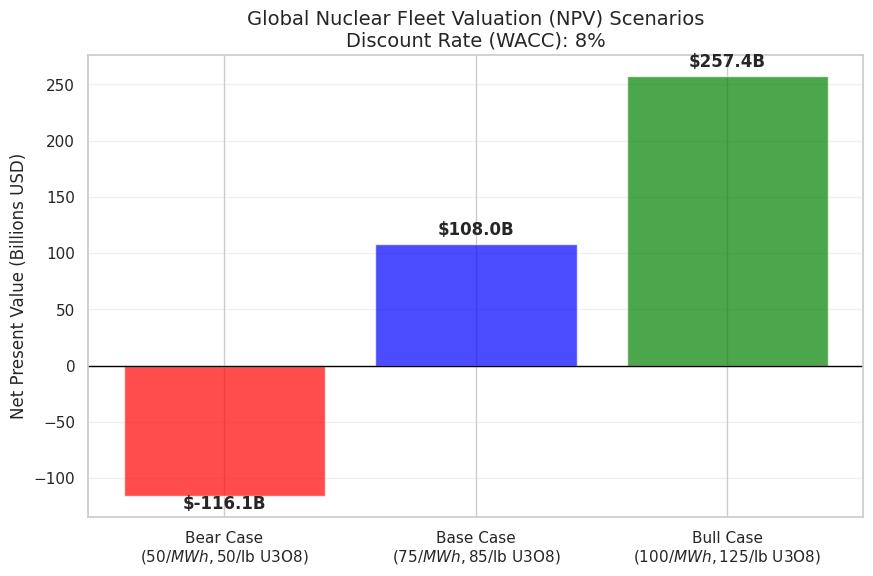


Top 10 Most Valuable Nuclear Assets (Base Case):
        Reactor name  PV_EBITDA_Base_Case
338     SHIN-HANUL-2             0.952753
285   PEACH BOTTOM-3             0.835835
19         BARAKAH-3             0.799528
284   PEACH BOTTOM-2             0.784858
44    BROWNS FERRY-2             0.772788
337     SHIN-HANUL-1             0.750766
125  FANGCHENGGANG-4             0.750180
348    SOUTH TEXAS-2             0.738064
230       LIMERICK-2             0.723348
41       BRAIDWOOD-1             0.710018
Final Valuation Model saved to 'fleet_valuation_final.csv'. Ready for Dashboard (Notebook 5).


In [15]:
print("Calculating Global Fleet Valuation...")

# 1. Sum the PVs to get Total NPV
total_npv_bear = df_financials['PV_EBITDA_Bear_Case'].sum()
total_npv_base = df_financials['PV_EBITDA_Base_Case'].sum()
total_npv_bull = df_financials['PV_EBITDA_Bull_Case'].sum()

# Convert to Billions
val_bear_B = total_npv_bear / 1e9
val_base_B = total_npv_base / 1e9
val_bull_B = total_npv_bull / 1e9

print(f"Global Nuclear Fleet Valuation (NPV @ {WACC:.0%}):")
print(f"  Bear Case: ${val_bear_B:.2f} Billion")
print(f"  Base Case: ${val_base_B:.2f} Billion")
print(f"  Bull Case: ${val_bull_B:.2f} Billion")

# 2. Plot: Valuation Comparison
plt.figure(figsize=(10, 6))
scenarios_labels = ['Bear Case\n($50/MWh, $50/lb U3O8)', 'Base Case\n($75/MWh, $85/lb U3O8)', 'Bull Case\n($100/MWh, $125/lb U3O8)']
values = [val_bear_B, val_base_B, val_bull_B]
colors = ['red', 'blue', 'green']

bars = plt.bar(scenarios_labels, values, color=colors, alpha=0.7)

# Add value labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (5 if yval > 0 else -15), f"${yval:.1f}B", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title(f'Global Nuclear Fleet Valuation (NPV) Scenarios\nDiscount Rate (WACC): {WACC:.0%}', fontsize=14)
plt.ylabel('Net Present Value (Billions USD)')
plt.axhline(0, color='black', linewidth=1)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 3. Insight: Top 10 Most Valuable Assets (Base Case)
# We group by reactor to find the individual asset NPVs
reactor_valuations = df_financials.groupby('Reactor name')['PV_EBITDA_Base_Case'].sum().reset_index()
top_10_assets = reactor_valuations.nlargest(10, 'PV_EBITDA_Base_Case')
top_10_assets['PV_EBITDA_Base_Case'] /= 1e9 # Convert to Billions

print("\nTop 10 Most Valuable Nuclear Assets (Base Case):")
print(top_10_assets)

# 4. Export
df_financials.to_csv('fleet_valuation_final.csv', index=False)
print("Final Valuation Model saved to 'fleet_valuation_final.csv'. Ready for Dashboard (Notebook 5).")